In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

In [21]:
# geting  inputs from user
stock_name = input("Enter the stock name: ")
start_date = input("Enter start date (yyyy-mm-dd): ")
end_date = input("Enter end date (yyyy-mm-dd): ")
time_frame = input("Enter time frame (e.g., 1d, 1wk, 1mo): ")

# stock_name = 'AAPL'
# start_date = '2010-09-21'
# end_date = '2020-09-21'
# time_frame = '1d'

Enter the stock name:  AAPL
Enter start date (yyyy-mm-dd):  2010-09-21
Enter end date (yyyy-mm-dd):  2023-09-21
Enter time frame (e.g., 1d, 1wk, 1mo):  1d


In [22]:
# getting data from yfinance 
data = yf.download(stock_name, start=start_date, end=end_date, interval=time_frame)

# adding  technical indicators to data 
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# making data clean by removing nan 
data.dropna(inplace=True)

C:\Users\VARAD\AppData\Local\Temp\ipykernel_16312\3568727617.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_name, start=start_date, end=end_date, interval=time_frame)
[*********************100%***********************]  1 of 1 completed


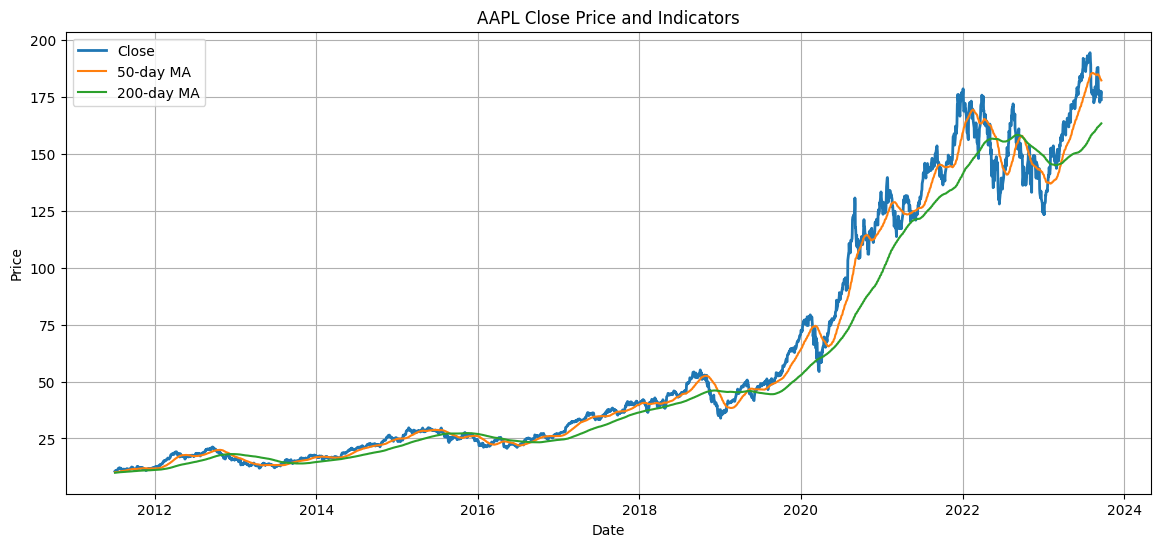

In [23]:
# ploting  close price and indicators
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close', linewidth=2)
plt.plot(data['MA50'], label='50-day MA')
plt.plot(data['MA200'], label='200-day MA')
plt.title(f"{stock_name} Close Price and Indicators")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# prepare data for model
features = data[['Close', 'MA50', 'MA200']]
labels = data[['Close']]


feature_scaler = MinMaxScaler()
label_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_labels = label_scaler.fit_transform(labels)

def create_sequences(features, labels, seq_length=60):
    # Adjust seq_length to be safe: no bigger than (len(features) - 1)
    seq_length = min(seq_length, len(features) - 1)
    
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i - seq_length:i])
        y.append(labels[i])
    
    return np.array(X), np.array(y)

# Usage:
X, y = create_sequences(scaled_features, scaled_labels)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Epoch 1 - Train Loss: 0.104316, Val Loss: 0.811496
Epoch 11 - Train Loss: 0.044440, Val Loss: 0.548018
Epoch 21 - Train Loss: 0.022478, Val Loss: 0.245903
Epoch 31 - Train Loss: 0.017669, Val Loss: 0.247512
R² Score: -1.5141799449920654


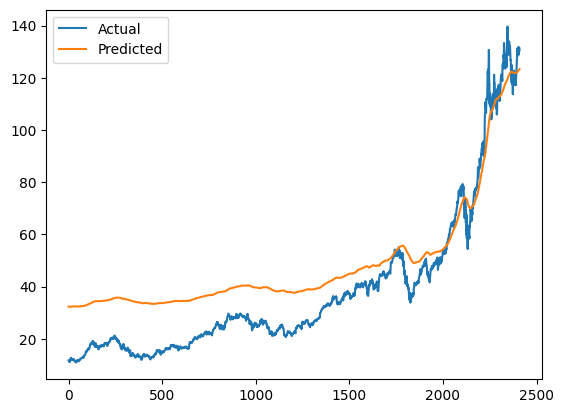

In [25]:
# define LSTM model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)  # Output layer

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Take only last time step output
        out = self.fc1(out)
        out = self.relu(out)
        return self.fc2(out)


# Define model
input_size = X_train.shape[2]  
hidden_size = 64
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(40):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)  
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output, y_test)  

    if (epoch % 10 == 0): 
         print(f"Epoch {epoch+1} - Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")


# evaluate model
r2 = r2_score(y_test, val_output)
print(f"R² Score: {r2}")

with torch.no_grad():
    preds = model(X_train)
    preds_inv = label_scaler.inverse_transform(preds.numpy())
    y_inv = label_scaler.inverse_transform(y_train.numpy())

# plotting Predicted v/s actual data
plt.plot(y_inv, label="Actual")
plt.plot(preds_inv, label="Predicted")
plt.legend()
plt.show()


In [26]:
# make prediction for next 15 days
last_seq = scaled_features[-60:]
current_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)
predicted_scaled = []

for _ in range(15):
    with torch.no_grad():
        next_price_scaled = model(current_seq).item()
      
        predicted_scaled.append(next_price_scaled)

        next_row = np.zeros((features.shape[1],))
        next_row[0] = next_price_scaled

        current_seq_np = current_seq.squeeze(0).numpy()
        current_seq_np = np.vstack([current_seq_np[1:], next_row])
        current_seq = torch.tensor(current_seq_np, dtype=torch.float32).unsqueeze(0)


# convert predicted values back to original scale
pred_scaled_arr = np.array(predicted_scaled).reshape(-1, 1)
pad = np.zeros((15, features.shape[1] - 1))
pred_full_scaled = np.concatenate([pred_scaled_arr, pad], axis=1)
predicted_15_prices = label_scaler.inverse_transform(pred_full_scaled)[:, 0]

# get actual future prices (if available)
start_dt = datetime.strptime(end_date, '%Y-%m-%d')
end_dt = start_dt + timedelta(days=20)
df_actual = yf.download(stock_name, start=start_dt, end=end_dt)
actual_close = df_actual['Close'].dropna().reset_index(drop=True)




C:\Users\VARAD\AppData\Local\Temp\ipykernel_16312\1545659719.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_actual = yf.download(stock_name, start=start_dt, end=end_dt)
[*********************100%***********************]  1 of 1 completed


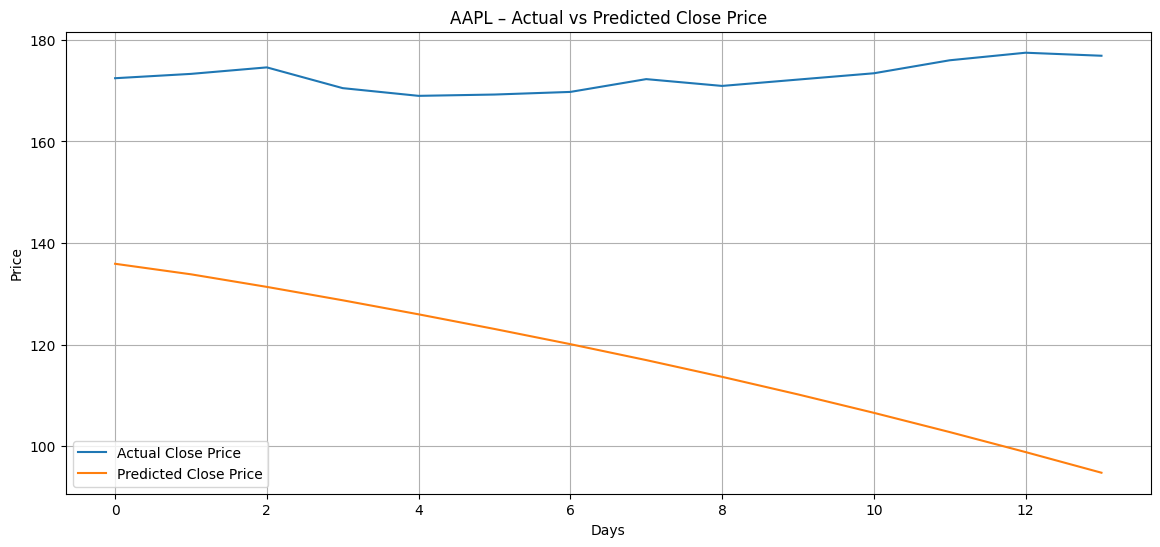

In [27]:
# prepare to plot
valid_len = min(len(actual_close), 15)
actual_prices = actual_close[:valid_len].values
predicted_prices = predicted_15_prices[:valid_len]

# plot predicted vs actual
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title(f"{stock_name} – Actual vs Predicted Close Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from datetime import datetime, timedelta

# Print predicted prices with corresponding dates
print(" Predicted Close Prices for the Next 15 Days:")
for i, price in enumerate(predicted_15_prices):
    pred_date = start_dt + timedelta(days=i+1)
    print(f"{pred_date.strftime('%Y-%m-%d')}: ₹{price:.2f}")


 Predicted Close Prices for the Next 15 Days:
2023-09-22: ₹135.92
2023-09-23: ₹133.85
2023-09-24: ₹131.37
2023-09-25: ₹128.74
2023-09-26: ₹125.98
2023-09-27: ₹123.10
2023-09-28: ₹120.10
2023-09-29: ₹116.97
2023-09-30: ₹113.68
2023-10-01: ₹110.22
2023-10-02: ₹106.59
2023-10-03: ₹102.80
2023-10-04: ₹98.87
2023-10-05: ₹94.80
2023-10-06: ₹90.65
